In [36]:
import torch
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch.nn.functional as F

import matplotlib.pyplot as plt

# --- 1. SETUP HARDWARE (The Speed Boost) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device.upper()}")

model_name = "FacebookAI/roberta-large-mnli"

# LOAD IN FP16 (Critical for Speed/Memory)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

#COMPILE MODEL (PyTorch 2.0+ Magic)
#If this errors (on older Windows), you can comment it out, but it's free speed.
#--- DELETE OR COMMENT OUT THIS BLOCK ---
try:
    model = torch.compile(model)
    print("Model compiled for faster inference.")
except Exception as e:
    print(f"Skipping compilation (not supported on this setup): {e}")

tokenizer = AutoTokenizer.from_pretrained(model_name)

Running on: CUDA


Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model compiled for faster inference.


In [37]:
data = pd.read_csv("data/samples/balanced_sample_20000.csv")

X_train, X_test, y_train, y_test = train_test_split(
    data[["selftext"]],
    data["target"],
    test_size=0.05,
    random_state=42,
    stratify=data["target"]
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=42,
    stratify=y_train
)

X_train.shape, X_val.shape, X_test.shape

((18040, 1), (950, 1), (1000, 1))

# Modelling

In [38]:
def predict_verdict_forced(post):
    hypothesis = "The author of this story is being an asshole."

    # 1. Encode
    input_ids = tokenizer.encode(
        post,
        hypothesis,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )

    # Move input_ids to the correct device (GPU)
    input_ids = input_ids.to(device)

    # 2. Get Logits
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits[0]  # Shape: [3] -> [Contradiction, Neutral, Entailment]

    # --- THE HEAVY LIFTING FIX ---
    # RoBERTa MNLI mapping: 0=Contradiction (NTA), 1=Neutral, 2=Entailment (YTA)

    # We slice out only indices 0 and 2
    binary_logits = torch.tensor([logits[0], logits[2]])

    # We re-calculate softmax on just these two options
    probs = F.softmax(binary_logits, dim=0)

    nta_prob = probs[0].item() # Contradiction
    yta_prob = probs[1].item() # Entailment (now index 1 of our binary tensor)

    # 3. Simple Decision
    if yta_prob > nta_prob:
        print(1)
        return 1 # YTA
    else:
        print(0)
        return 0 # NTA

# --- Run your loop again with this function ---

X_val['prediction'] = X_val['selftext'].apply(predict_verdict_forced)

0
1
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
0
0
1
1
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
1
1
0
0
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
0
0
0
1
0
1
1
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
0
1
0
1
0
1
0
0
0
1
0
1
0
1
1
0
0
0
0
0
0
1
1
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
1
0
0
1
0
0
0
0
0
1
0
0
0
1
0
0
0
1
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
1
0
1
0
1
0
0
0
0
1
0
0
0
0
0
1
1
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
1
1
1
0
1
0
1
0
1
0
0
0
0
1
1
1
0
0
1
0
0
0
1
0
0
1
0
0
0
1
0
0
0
1
1
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
1
1
0
0
1
0
0
1
0
0
1
0
1
0
0
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
1
0
1
0
0
1
1
0
1
0
1
0
1
0
0
0
1
1
0
1
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0


              precision    recall  f1-score   support

           0       0.50      0.73      0.59       475
           1       0.49      0.26      0.34       475

    accuracy                           0.50       950
   macro avg       0.49      0.50      0.47       950
weighted avg       0.49      0.50      0.47       950



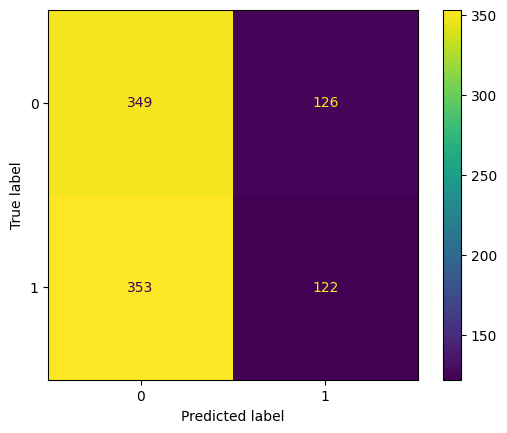

In [39]:
print(classification_report(y_val, X_val["prediction"], zero_division=0))
cm = confusion_matrix(y_val, X_val["prediction"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

# More hypotheses

In [50]:
# --- 1. DEFINE YOUR EXPERTS (The Hypotheses) ---
# We use diverse phrasing to catch different nuances of morality.
HYPOTHESES = [
    # Group A: YTA Signals (Expect High Entailment = YTA)
    "The author of this story is being an asshole.",
    "The narrator acted rudely.",
    "The protagonist was unreasonable.",
    "The author is in the wrong.",
    "The narrator's behavior was unacceptable.",

    # Group B: NTA Signals (Expect High Entailment = NTA)
    "The author acted reasonably.",
    "The narrator was justified in their actions.",
    "The author is the victim here.",
    "The other person was the aggressor.",
    "The narrator handled the situation well.",

    # Group C: Emotional/Abstract Signals (Let XGBoost figure these out)
    "This situation is complicated.",
    "The author is feeling guilty.",
    "The author is angry.",
    "The conflict was unavoidable."
]

def extract_hypothesis_features(texts, model, tokenizer, batch_size=8):
    """
    Takes a list of texts and returns a DataFrame of hypothesis scores.
    """
    device = model.device
    all_features = []

    # We process in batches to speed up the GPU/CPU throughput
    for i in tqdm(range(0, len(texts), batch_size), desc="Extracting Features"):
        batch_texts = texts[i : i + batch_size]

        # Temporary storage for this batch's features
        # Shape: [batch_size, num_hypotheses]
        batch_scores = {f"h_{j}": [] for j in range(len(HYPOTHESES))}

        for h_idx, hypothesis in enumerate(HYPOTHESES):
            # Create pairs: [("Text 1", "Hypothesis A"), ("Text 2", "Hypothesis A")...]
            pairs = [[text, hypothesis] for text in batch_texts]

            # Tokenize
            inputs = tokenizer(
                pairs,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=512
            ).to(device)

            # Inference
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

            # RoBERTa MNLI: Index 2 is usually "Entailment"
            # We apply softmax and grab column 2
            probs = torch.softmax(logits, dim=1)
            entailment_scores = probs[:, 2].cpu().numpy()

            # Store
            batch_scores[f"h_{h_idx}"].extend(entailment_scores)

        # Transpose the batch dict to a list of row-vectors
        # (This is a bit quick-and-dirty, but effective)
        for k in range(len(batch_texts)):
            row = {key: batch_scores[key][k] for key in batch_scores}
            all_features.append(row)

    return pd.DataFrame(all_features)

# --- HOW TO USE IT ---
# 1. Grab a small chunk of your data to test
# OLD/BROKEN: subset = X_val.select(range(50))
subset = X_val.copy() # Use .iloc for Pandas
texts = subset['selftext'].tolist() # Convert to list to be safe for the tokenizer

# 2. Extract Features (This is the slow part!)
print(f"Running inference on {len(texts)} texts against {len(HYPOTHESES)} hypotheses...")
X_features = extract_hypothesis_features(texts, model, tokenizer, batch_size=4)

Running inference on 950 texts against 14 hypotheses...


Extracting Features:   0%|          | 0/238 [00:00<?, ?it/s]

In [57]:
meta_data = pd.concat([y_val.reset_index(), X_features.reset_index()], axis=1)
meta_data.corr()["target"].iloc[3:]



,target
h_0,0.061602
h_1,0.048387
h_2,0.060118
h_3,0.054180
h_4,0.026020
h_5,0.070511
h_6,0.065934
h_7,0.038419
h_8,0.030880
h_9,0.029383
